### 5.5) Gathering Input Graphs

In [1]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 64.2 MB/s eta 0:00:0000:010:01
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 33.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.1 MB/s eta 0:00:00a 0:00:01


In [2]:
import torch
from torch_geometric.data import Data
from torch.serialization import add_safe_globals
import os

# Allow PyTorch to unpickle torch_geometric.data.Data objects
add_safe_globals([Data])

# Then load the files
graph_dir = "/kaggle/input/chicken-graph-data-edge-attr/graph_data_zip"
pt_files = [f for f in os.listdir(graph_dir) if f.endswith('.pt')]

graphs = [
    torch.load(os.path.join(graph_dir, f), weights_only=False)
    for f in pt_files
]

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_scatter_cuda.so: undefined symbol: _ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_St8optionalIN3c1017basic_string_viewIcEEE
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_spmm_cuda.so: undefined symbol: _ZN5torch8autograd12VariableInfoC1ERKN2at6TensorE
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [3]:
graphs

[Data(x=[560, 560], edge_index=[2, 440258], edge_attr=[440258, 3], y=[1]),
 Data(x=[603, 603], edge_index=[2, 319768], edge_attr=[319768, 3], y=[1]),
 Data(x=[525, 525], edge_index=[2, 92854], edge_attr=[92854, 3], y=[1]),
 Data(x=[648, 648], edge_index=[2, 477458], edge_attr=[477458, 3], y=[1]),
 Data(x=[484, 484], edge_index=[2, 327346], edge_attr=[327346, 3], y=[1]),
 Data(x=[430, 430], edge_index=[2, 295144], edge_attr=[295144, 3], y=[1]),
 Data(x=[716, 716], edge_index=[2, 348140], edge_attr=[348140, 3], y=[1]),
 Data(x=[706, 706], edge_index=[2, 401906], edge_attr=[401906, 3], y=[1]),
 Data(x=[577, 577], edge_index=[2, 488282], edge_attr=[488282, 3], y=[1]),
 Data(x=[599, 599], edge_index=[2, 582338], edge_attr=[582338, 3], y=[1]),
 Data(x=[451, 451], edge_index=[2, 274074], edge_attr=[274074, 3], y=[1]),
 Data(x=[426, 426], edge_index=[2, 277242], edge_attr=[277242, 3], y=[1]),
 Data(x=[591, 591], edge_index=[2, 571268], edge_attr=[571268, 3], y=[1]),
 Data(x=[199, 199], edge_in

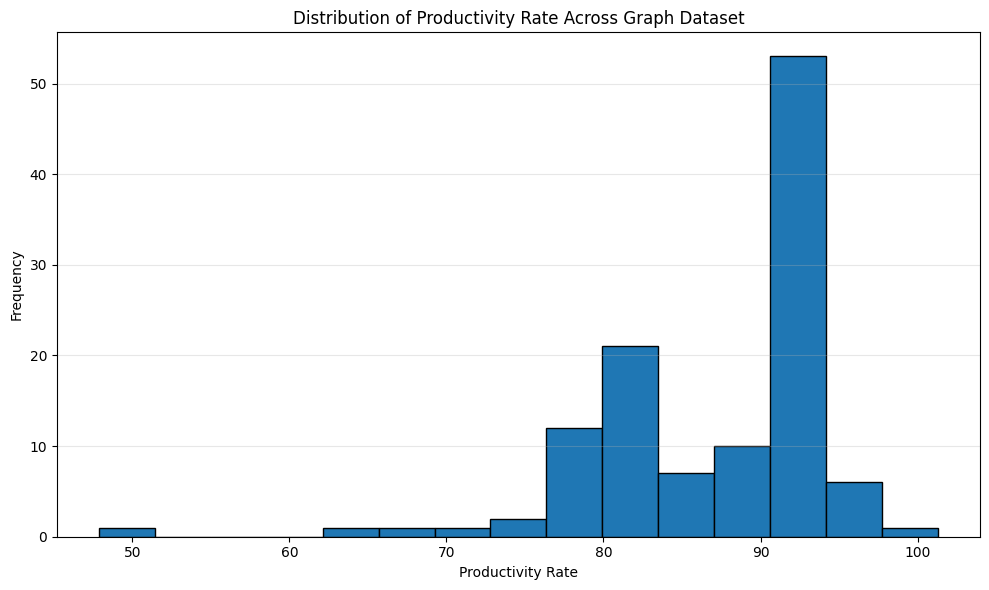

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

rates = []
for graph in graphs:
    if hasattr(graph, 'y'):
        val = graph.y.item() if graph.y.numel() == 1 else float(graph.y[0])
        rates.append(val)

plt.figure(figsize=(10, 6))
plt.hist(rates, bins=15, edgecolor='black')
plt.xlabel("Productivity Rate")
plt.ylabel("Frequency")
plt.title("Distribution of Productivity Rate Across Graph Dataset")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Productivity rate = (Eggs Laid / Number of Hens) x 100.

The majority of days are over 90, which is a high productivity rate. The smallest rate was under 60 one day and the largest was a perfect 100.

In [5]:
# padding so model can expect a fixed set of dimensions from graphs

max_node_dim = max(g.x.shape[1] for g in graphs)
max_edge_dim = max(g.edge_attr.shape[1] for g in graphs)

def pad_features(graph, max_node_dim, max_edge_dim):
    # Pad node features
    node_feat = graph.x
    if node_feat.shape[1] < max_node_dim:
        pad_size = max_node_dim - node_feat.shape[1]
        padding = torch.zeros((node_feat.shape[0], pad_size), dtype=node_feat.dtype)
        graph.x = torch.cat([node_feat, padding], dim=1)
    
    # Pad edge features
    edge_feat = graph.edge_attr
    if edge_feat.shape[1] < max_edge_dim:
        pad_size = max_edge_dim - edge_feat.shape[1]
        padding = torch.zeros((edge_feat.shape[0], pad_size), dtype=edge_feat.dtype)
        graph.edge_attr = torch.cat([edge_feat, padding], dim=1)
    
    return graph

In [6]:
graphs_padded = [pad_features(g, max_node_dim, max_edge_dim) for g in graphs]

### 6) Create GAT Model for Graph Regression¶

GAT model takes graph as input, applies GAT layers to learn node embeddings, aggregates (mean pooling or attention pooling) to a graph level embedding, and passes that to fully connected layers to predict a single value (productivity)

global mean pooling

In [15]:
# using edge_attr properly

import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

class GATGraphRegressor(torch.nn.Module):
    def __init__(self, in_node_feats, in_edge_feats, hidden_dim=64, heads=4):
        super(GATGraphRegressor, self).__init__()
        self.gat1 = GATv2Conv(in_node_feats, hidden_dim, heads=heads, concat=True, dropout=0.2, edge_dim=in_edge_feats)
        self.gat2 = GATv2Conv(hidden_dim * heads, hidden_dim, heads=1, concat=True, dropout=0.2, edge_dim=in_edge_feats)

        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = self.gat1(x, edge_index, edge_attr)
        x = F.elu(x)
        x = self.gat2(x, edge_index, edge_attr)
        x = F.elu(x)
        x = global_mean_pool(x, batch)
        return self.mlp(x).squeeze(1)

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    losses = []
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

def eval_model(model, loader, criterion, device):
    model.eval()
    losses = []
    preds, targets = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            loss = criterion(out, batch.y.view(-1))
            losses.append(loss.item())
            preds.extend(out.cpu().numpy())
            targets.extend(batch.y.view(-1).cpu().numpy())
    rmse = mean_squared_error(targets, preds, squared=False)
    mae = mean_absolute_error(targets, preds)
    return np.mean(losses), rmse, mae, preds, targets

# Replace these with your actual data and dimensions
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Make sure `graphs_padded` is defined and has x, edge_index, edge_attr, y, batch
# Also make sure all graphs have same node feature dimension and edge feature dimension
in_node_feats = graphs_padded[0].x.shape[1]
in_edge_feats = graphs_padded[0].edge_attr.shape[1]

all_rmse = []
all_mae = []

for fold, (train_idx, val_idx) in enumerate(kf.split(graphs_padded)):
    print(f"Fold {fold + 1}")
    train_dataset = [graphs_padded[i] for i in train_idx]
    val_dataset = [graphs_padded[i] for i in val_idx]

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    model = GATGraphRegressor(in_node_feats=in_node_feats, in_edge_feats=in_edge_feats).to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(100):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, rmse, mae, _, _ = eval_model(model, val_loader, criterion, device)
        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_model_fold{fold}.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

    # Load best model and evaluate on validation set
    model.load_state_dict(torch.load(f"best_model_fold{fold}.pt"))
    _, rmse, mae, preds, targets = eval_model(model, val_loader, criterion, device)
    all_rmse.append(rmse)
    all_mae.append(mae)
    print(f"Fold {fold + 1} final RMSE: {rmse:.4f}, MAE: {mae:.4f}")

print(f"\nAverage RMSE: {np.mean(all_rmse):.4f} ± {np.std(all_rmse):.4f}")
print(f"Average MAE: {np.mean(all_mae):.4f} ± {np.std(all_mae):.4f}")


Fold 1
Epoch 0 | Train Loss: 1.1084 | Val Loss: 0.6275 | RMSE: 0.7921 | MAE: 0.7227
Epoch 1 | Train Loss: 1.0954 | Val Loss: 0.6430 | RMSE: 0.8019 | MAE: 0.7260
Epoch 2 | Train Loss: 1.0900 | Val Loss: 0.6595 | RMSE: 0.8121 | MAE: 0.7308
Epoch 3 | Train Loss: 1.0860 | Val Loss: 0.6690 | RMSE: 0.8179 | MAE: 0.7338
Epoch 4 | Train Loss: 1.0861 | Val Loss: 0.6907 | RMSE: 0.8311 | MAE: 0.7398
Epoch 5 | Train Loss: 1.0918 | Val Loss: 0.7223 | RMSE: 0.8499 | MAE: 0.7511
Epoch 6 | Train Loss: 1.0985 | Val Loss: 0.7439 | RMSE: 0.8625 | MAE: 0.7576
Epoch 7 | Train Loss: 1.1073 | Val Loss: 0.8019 | RMSE: 0.8955 | MAE: 0.7738
Epoch 8 | Train Loss: 1.1399 | Val Loss: 0.8513 | RMSE: 0.9226 | MAE: 0.7846
Epoch 9 | Train Loss: 1.1663 | Val Loss: 0.9393 | RMSE: 0.9692 | MAE: 0.8100
Epoch 10 | Train Loss: 1.1931 | Val Loss: 0.9935 | RMSE: 0.9967 | MAE: 0.8231
Early stopping
Fold 1 final RMSE: 0.7921, MAE: 0.7227
Fold 2
Epoch 0 | Train Loss: 1.1078 | Val Loss: 0.6243 | RMSE: 0.7901 | MAE: 0.7166
Epoch 1

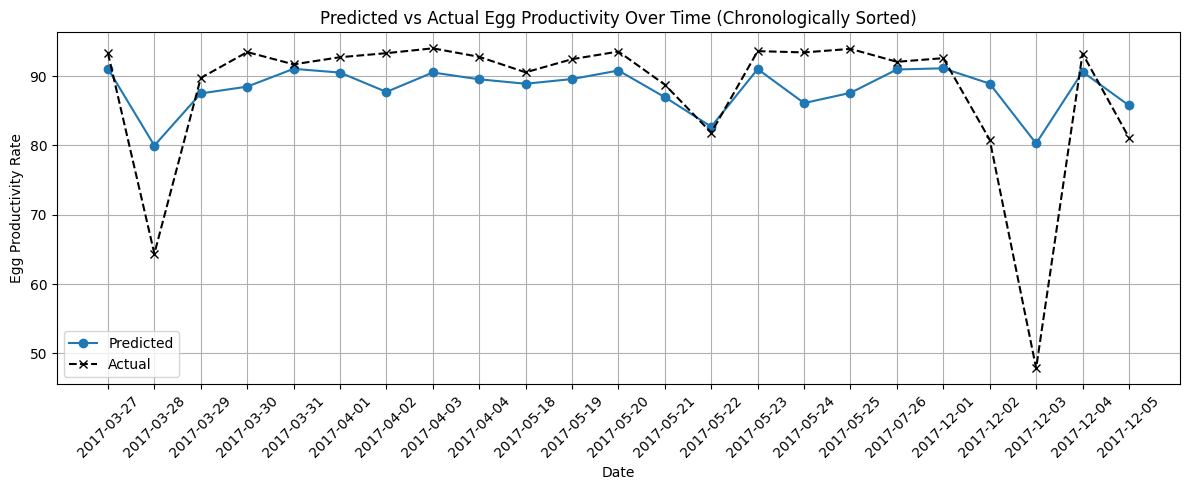

In [8]:
target = pd.read_csv("/kaggle/input/private-hen-productivity-target-labels/production_net.csv", sep=";")
eggs_per_day_df = target[["date", "Laying.rate...."]].rename(columns={"Laying.rate....": "productivity rate"})
eggs_per_day_df['productivity rate'] = eggs_per_day_df['productivity rate'].str.replace(',', '.').astype(float)

n = len(preds)
dates = eggs_per_day_df["date"].iloc[-n:].reset_index(drop=True)

# Combine into a single dataframe and sort by date
df_plot = pd.DataFrame({
    "date": dates,
    "predicted": preds,
    "actual": targets
}).sort_values("date")

plt.figure(figsize=(12, 5))
plt.plot(df_plot["date"], df_plot["predicted"], label="Predicted", marker='o')
plt.plot(df_plot["date"], df_plot["actual"], label="Actual", linestyle="--", color="black", marker='x')
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Egg Productivity Rate")
plt.title("Predicted vs Actual Egg Productivity Over Time (Chronologically Sorted)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

global_max_pool instead of global_mean_pool

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_max_pool
from torch_geometric.loader import DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

class GATGraphRegressor(torch.nn.Module):
    def __init__(self, in_node_feats, edge_dim, hidden_dim=64, heads=4):
        super(GATGraphRegressor, self).__init__()
        self.gat1 = GATConv(in_node_feats, hidden_dim, heads=heads, concat=True, dropout=0.2, edge_dim=edge_dim, add_self_loops=False)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, concat=True, dropout=0.2, edge_dim=edge_dim, add_self_loops=False)

        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = self.gat1(x, edge_index, edge_attr)
        x = F.elu(x)
        x = self.gat2(x, edge_index, edge_attr)
        x = F.elu(x)
        x = global_max_pool(x, batch)
        return self.mlp(x).squeeze(1)

# Normalize targets
ys_all = [g.y.item() for g in graphs_padded]
mean_y = np.mean(ys_all)
std_y = np.std(ys_all)

for g in graphs_padded:
    g.y = torch.tensor([(g.y.item() - mean_y) / std_y], dtype=torch.float)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

kf = KFold(n_splits=5, shuffle=True, random_state=0)

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    losses = []
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y.view(-1))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

def eval_model(model, loader, criterion):
    model.eval()
    losses = []
    preds, targets = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            loss = criterion(out, batch.y.view(-1))
            losses.append(loss.item())
            preds.extend(out.cpu().numpy())
            targets.extend(batch.y.view(-1).cpu().numpy())
    rmse = mean_squared_error(targets, preds, squared=False)
    mae = mean_absolute_error(targets, preds)
    return np.mean(losses), rmse, mae, preds, targets

all_rmse = []
all_mae = []

# Assume edge_attr is consistent across graphs and has fixed dim
edge_dim = graphs_padded[0].edge_attr.shape[1]

for fold, (train_idx, val_idx) in enumerate(kf.split(graphs_padded)):
    print(f"Fold {fold + 1}")
    train_dataset = [graphs_padded[i] for i in train_idx]
    val_dataset = [graphs_padded[i] for i in val_idx]

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    model = GATGraphRegressor(in_node_feats=max_node_dim, edge_dim=edge_dim).to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(100):
        train_loss = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, rmse, mae, _, _ = eval_model(model, val_loader, criterion)
        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_model_max_fold{fold}.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(torch.load(f"best_model_max_fold{fold}.pt"))
    _, rmse, mae, preds, targets = eval_model(model, val_loader, criterion)
    all_rmse.append(rmse)
    all_mae.append(mae)
    print(f"Fold {fold + 1} final RMSE: {rmse:.4f}, MAE: {mae:.4f}")

print(f"\nAverage RMSE: {np.mean(all_rmse):.4f} ± {np.std(all_rmse):.4f}")
print(f"Average MAE: {np.mean(all_mae):.4f} ± {np.std(all_mae):.4f}")

Fold 1


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0 | Train Loss: 1.1008 | Val Loss: 0.6340 | RMSE: 0.7962 | MAE: 0.7245


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 4 | Train Loss: 1.0533 | Val Loss: 0.6959 | RMSE: 0.8342 | MAE: 0.7601


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 5 | Train Loss: 1.0396 | Val Loss: 0.6990 | RMSE: 0.8360 | MAE: 0.7624


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 6 | Train Loss: 1.0317 | Val Loss: 0.7064 | RMSE: 0.8405 | MAE: 0.7641


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 7 | Train Loss: 1.0242 | Val Loss: 0.7091 | RMSE: 0.8421 | MAE: 0.7675


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 8 | Train Loss: 1.0196 | Val Loss: 0.7183 | RMSE: 0.8475 | MAE: 0.7718


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 9 | Train Loss: 1.0181 | Val Loss: 0.7171 | RMSE: 0.8468 | MAE: 0.7709


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 10 | Train Loss: 1.0023 | Val Loss: 0.6996 | RMSE: 0.8364 | MAE: 0.7599
Early stopping triggered.
Fold 2 final RMSE: 0.7904, MAE: 0.7163
Fold 3


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0 | Train Loss: 1.0279 | Val Loss: 0.9118 | RMSE: 0.9549 | MAE: 0.8364


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1 | Train Loss: 1.0218 | Val Loss: 0.9098 | RMSE: 0.9538 | MAE: 0.8354


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 2 | Train Loss: 1.0147 | Val Loss: 0.9118 | RMSE: 0.9549 | MAE: 0.8347


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 3 | Train Loss: 1.0083 | Val Loss: 0.9111 | RMSE: 0.9545 | MAE: 0.8366


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 4 | Train Loss: 0.9994 | Val Loss: 0.9145 | RMSE: 0.9563 | MAE: 0.8369


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 5 | Train Loss: 0.9962 | Val Loss: 0.9136 | RMSE: 0.9558 | MAE: 0.8364


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 6 | Train Loss: 0.9859 | Val Loss: 0.9102 | RMSE: 0.9541 | MAE: 0.8327


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 7 | Train Loss: 0.9727 | Val Loss: 0.9090 | RMSE: 0.9534 | MAE: 0.8335


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 8 | Train Loss: 0.9611 | Val Loss: 0.8985 | RMSE: 0.9479 | MAE: 0.8293


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 9 | Train Loss: 0.9556 | Val Loss: 0.8997 | RMSE: 0.9485 | MAE: 0.8310


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 10 | Train Loss: 0.9309 | Val Loss: 0.8959 | RMSE: 0.9465 | MAE: 0.8304


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 11 | Train Loss: 0.9154 | Val Loss: 0.8862 | RMSE: 0.9414 | MAE: 0.8214


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 12 | Train Loss: 0.8741 | Val Loss: 0.8701 | RMSE: 0.9328 | MAE: 0.8136


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 13 | Train Loss: 0.8380 | Val Loss: 0.8638 | RMSE: 0.9294 | MAE: 0.8077


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 14 | Train Loss: 0.8054 | Val Loss: 0.8474 | RMSE: 0.9206 | MAE: 0.7989


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 15 | Train Loss: 0.7508 | Val Loss: 0.8145 | RMSE: 0.9025 | MAE: 0.7859


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 16 | Train Loss: 0.6975 | Val Loss: 0.7872 | RMSE: 0.8872 | MAE: 0.7638


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 17 | Train Loss: 0.6278 | Val Loss: 0.7743 | RMSE: 0.8800 | MAE: 0.7620


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 18 | Train Loss: 0.5771 | Val Loss: 0.7502 | RMSE: 0.8661 | MAE: 0.7383


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 19 | Train Loss: 0.4944 | Val Loss: 0.6938 | RMSE: 0.8330 | MAE: 0.7073


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 20 | Train Loss: 0.4234 | Val Loss: 0.6464 | RMSE: 0.8040 | MAE: 0.6784


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 21 | Train Loss: 0.4071 | Val Loss: 0.5790 | RMSE: 0.7609 | MAE: 0.6380


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 22 | Train Loss: 0.3329 | Val Loss: 0.5802 | RMSE: 0.7617 | MAE: 0.6305


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 23 | Train Loss: 0.2864 | Val Loss: 0.5388 | RMSE: 0.7340 | MAE: 0.6077


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 24 | Train Loss: 0.2589 | Val Loss: 0.5377 | RMSE: 0.7333 | MAE: 0.5944


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 25 | Train Loss: 0.2509 | Val Loss: 0.5210 | RMSE: 0.7218 | MAE: 0.5954


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 26 | Train Loss: 0.2308 | Val Loss: 0.4737 | RMSE: 0.6883 | MAE: 0.5505


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 27 | Train Loss: 0.1964 | Val Loss: 0.4824 | RMSE: 0.6946 | MAE: 0.5626


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 28 | Train Loss: 0.1724 | Val Loss: 0.4748 | RMSE: 0.6891 | MAE: 0.5706


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 29 | Train Loss: 0.1579 | Val Loss: 0.4638 | RMSE: 0.6811 | MAE: 0.5495


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 30 | Train Loss: 0.1568 | Val Loss: 0.4644 | RMSE: 0.6815 | MAE: 0.5447


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 31 | Train Loss: 0.1424 | Val Loss: 0.4564 | RMSE: 0.6756 | MAE: 0.5583


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 32 | Train Loss: 0.1185 | Val Loss: 0.4757 | RMSE: 0.6897 | MAE: 0.5800


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 33 | Train Loss: 0.1466 | Val Loss: 0.4466 | RMSE: 0.6683 | MAE: 0.5552


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 34 | Train Loss: 0.1370 | Val Loss: 0.4396 | RMSE: 0.6631 | MAE: 0.5294


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 35 | Train Loss: 0.1431 | Val Loss: 0.4760 | RMSE: 0.6899 | MAE: 0.5716


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 36 | Train Loss: 0.1601 | Val Loss: 0.4649 | RMSE: 0.6819 | MAE: 0.5633


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 37 | Train Loss: 0.1337 | Val Loss: 0.4679 | RMSE: 0.6840 | MAE: 0.5609


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 38 | Train Loss: 0.1130 | Val Loss: 0.4292 | RMSE: 0.6551 | MAE: 0.5402


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 39 | Train Loss: 0.1088 | Val Loss: 0.4144 | RMSE: 0.6438 | MAE: 0.5179


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 40 | Train Loss: 0.1207 | Val Loss: 0.4379 | RMSE: 0.6618 | MAE: 0.5317


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 41 | Train Loss: 0.0993 | Val Loss: 0.4270 | RMSE: 0.6535 | MAE: 0.5393


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 42 | Train Loss: 0.0911 | Val Loss: 0.4135 | RMSE: 0.6431 | MAE: 0.5147


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 43 | Train Loss: 0.1080 | Val Loss: 0.4381 | RMSE: 0.6619 | MAE: 0.5476


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 44 | Train Loss: 0.0815 | Val Loss: 0.4400 | RMSE: 0.6633 | MAE: 0.5474


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 45 | Train Loss: 0.0602 | Val Loss: 0.4497 | RMSE: 0.6706 | MAE: 0.5566


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 46 | Train Loss: 0.0643 | Val Loss: 0.4391 | RMSE: 0.6626 | MAE: 0.5458


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 47 | Train Loss: 0.0632 | Val Loss: 0.4764 | RMSE: 0.6902 | MAE: 0.5744


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 48 | Train Loss: 0.0666 | Val Loss: 0.4751 | RMSE: 0.6893 | MAE: 0.5922


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 49 | Train Loss: 0.0475 | Val Loss: 0.4776 | RMSE: 0.6911 | MAE: 0.5656


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 50 | Train Loss: 0.0632 | Val Loss: 0.4521 | RMSE: 0.6724 | MAE: 0.5623


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 51 | Train Loss: 0.0484 | Val Loss: 0.4776 | RMSE: 0.6911 | MAE: 0.5549


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 52 | Train Loss: 0.0423 | Val Loss: 0.4938 | RMSE: 0.7027 | MAE: 0.5896
Early stopping triggered.
Fold 3 final RMSE: 0.6431, MAE: 0.5147
Fold 4


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0 | Train Loss: 1.0477 | Val Loss: 0.8295 | RMSE: 0.9108 | MAE: 0.8160


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1 | Train Loss: 1.0420 | Val Loss: 0.8304 | RMSE: 0.9113 | MAE: 0.8150


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 2 | Train Loss: 1.0341 | Val Loss: 0.8336 | RMSE: 0.9130 | MAE: 0.8160


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 3 | Train Loss: 1.0299 | Val Loss: 0.8306 | RMSE: 0.9114 | MAE: 0.8146


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 4 | Train Loss: 1.0213 | Val Loss: 0.8309 | RMSE: 0.9115 | MAE: 0.8139


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 5 | Train Loss: 1.0120 | Val Loss: 0.8301 | RMSE: 0.9111 | MAE: 0.8119


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 6 | Train Loss: 1.0042 | Val Loss: 0.8295 | RMSE: 0.9108 | MAE: 0.8107


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 7 | Train Loss: 0.9989 | Val Loss: 0.8252 | RMSE: 0.9084 | MAE: 0.8104


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 8 | Train Loss: 0.9771 | Val Loss: 0.8258 | RMSE: 0.9087 | MAE: 0.8093


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 9 | Train Loss: 0.9708 | Val Loss: 0.8248 | RMSE: 0.9082 | MAE: 0.8086


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 10 | Train Loss: 0.9530 | Val Loss: 0.8149 | RMSE: 0.9027 | MAE: 0.8015


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 11 | Train Loss: 0.9283 | Val Loss: 0.8129 | RMSE: 0.9016 | MAE: 0.8014


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 12 | Train Loss: 0.9142 | Val Loss: 0.8051 | RMSE: 0.8973 | MAE: 0.7991


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 13 | Train Loss: 0.8912 | Val Loss: 0.7836 | RMSE: 0.8852 | MAE: 0.7898


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 14 | Train Loss: 0.8714 | Val Loss: 0.7731 | RMSE: 0.8793 | MAE: 0.7829


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 15 | Train Loss: 0.8330 | Val Loss: 0.7690 | RMSE: 0.8769 | MAE: 0.7812


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 16 | Train Loss: 0.7898 | Val Loss: 0.7309 | RMSE: 0.8549 | MAE: 0.7544


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 17 | Train Loss: 0.7309 | Val Loss: 0.7203 | RMSE: 0.8487 | MAE: 0.7527


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 18 | Train Loss: 0.6831 | Val Loss: 0.6912 | RMSE: 0.8314 | MAE: 0.7396


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 19 | Train Loss: 0.6205 | Val Loss: 0.6519 | RMSE: 0.8074 | MAE: 0.7153


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 20 | Train Loss: 0.5741 | Val Loss: 0.6344 | RMSE: 0.7965 | MAE: 0.7039


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 21 | Train Loss: 0.4952 | Val Loss: 0.6114 | RMSE: 0.7819 | MAE: 0.6891


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 22 | Train Loss: 0.4415 | Val Loss: 0.5659 | RMSE: 0.7523 | MAE: 0.6453


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 23 | Train Loss: 0.3780 | Val Loss: 0.5229 | RMSE: 0.7231 | MAE: 0.6245


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 24 | Train Loss: 0.3331 | Val Loss: 0.5154 | RMSE: 0.7179 | MAE: 0.6209


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 25 | Train Loss: 0.2900 | Val Loss: 0.4906 | RMSE: 0.7004 | MAE: 0.6101


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 26 | Train Loss: 0.2518 | Val Loss: 0.4668 | RMSE: 0.6832 | MAE: 0.5651


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 27 | Train Loss: 0.2661 | Val Loss: 0.5117 | RMSE: 0.7153 | MAE: 0.6079


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 28 | Train Loss: 0.2452 | Val Loss: 0.4757 | RMSE: 0.6897 | MAE: 0.5838


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 29 | Train Loss: 0.1858 | Val Loss: 0.4534 | RMSE: 0.6733 | MAE: 0.5626


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 30 | Train Loss: 0.1904 | Val Loss: 0.4757 | RMSE: 0.6897 | MAE: 0.5957


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 31 | Train Loss: 0.1441 | Val Loss: 0.4354 | RMSE: 0.6598 | MAE: 0.5588


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 32 | Train Loss: 0.1686 | Val Loss: 0.4463 | RMSE: 0.6681 | MAE: 0.5710


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 33 | Train Loss: 0.1438 | Val Loss: 0.4549 | RMSE: 0.6745 | MAE: 0.5755


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 34 | Train Loss: 0.1372 | Val Loss: 0.4794 | RMSE: 0.6924 | MAE: 0.5967


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 35 | Train Loss: 0.1166 | Val Loss: 0.4369 | RMSE: 0.6610 | MAE: 0.5541


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 36 | Train Loss: 0.1158 | Val Loss: 0.4441 | RMSE: 0.6664 | MAE: 0.5753


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 37 | Train Loss: 0.1156 | Val Loss: 0.4509 | RMSE: 0.6715 | MAE: 0.5802


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 38 | Train Loss: 0.1005 | Val Loss: 0.4396 | RMSE: 0.6630 | MAE: 0.5596


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 39 | Train Loss: 0.1034 | Val Loss: 0.4628 | RMSE: 0.6803 | MAE: 0.5866


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 40 | Train Loss: 0.0620 | Val Loss: 0.4602 | RMSE: 0.6784 | MAE: 0.5582


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 41 | Train Loss: 0.0796 | Val Loss: 0.4395 | RMSE: 0.6630 | MAE: 0.5434
Early stopping triggered.
Fold 4 final RMSE: 0.6598, MAE: 0.5588
Fold 5


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0 | Train Loss: 0.7664 | Val Loss: 1.9403 | RMSE: 1.3930 | MAE: 0.9670


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1 | Train Loss: 0.7615 | Val Loss: 1.9401 | RMSE: 1.3929 | MAE: 0.9670


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 2 | Train Loss: 0.7553 | Val Loss: 1.9384 | RMSE: 1.3923 | MAE: 0.9637


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 3 | Train Loss: 0.7489 | Val Loss: 1.9387 | RMSE: 1.3924 | MAE: 0.9639


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 4 | Train Loss: 0.7417 | Val Loss: 1.9367 | RMSE: 1.3916 | MAE: 0.9661


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 5 | Train Loss: 0.7337 | Val Loss: 1.9367 | RMSE: 1.3916 | MAE: 0.9610


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 6 | Train Loss: 0.7233 | Val Loss: 1.9238 | RMSE: 1.3870 | MAE: 0.9549


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 7 | Train Loss: 0.7136 | Val Loss: 1.9192 | RMSE: 1.3853 | MAE: 0.9499


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 8 | Train Loss: 0.6896 | Val Loss: 1.9135 | RMSE: 1.3833 | MAE: 0.9451


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 9 | Train Loss: 0.6700 | Val Loss: 1.9131 | RMSE: 1.3831 | MAE: 0.9412


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 10 | Train Loss: 0.6411 | Val Loss: 1.8971 | RMSE: 1.3773 | MAE: 0.9366


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 11 | Train Loss: 0.6116 | Val Loss: 1.8851 | RMSE: 1.3730 | MAE: 0.9407


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 12 | Train Loss: 0.5808 | Val Loss: 1.8651 | RMSE: 1.3657 | MAE: 0.9254


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 13 | Train Loss: 0.5295 | Val Loss: 1.8254 | RMSE: 1.3511 | MAE: 0.8924


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 14 | Train Loss: 0.4727 | Val Loss: 1.8248 | RMSE: 1.3508 | MAE: 0.9063


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 15 | Train Loss: 0.4219 | Val Loss: 1.7567 | RMSE: 1.3254 | MAE: 0.8630


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 16 | Train Loss: 0.3731 | Val Loss: 1.7264 | RMSE: 1.3139 | MAE: 0.8665


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 17 | Train Loss: 0.2905 | Val Loss: 1.7015 | RMSE: 1.3044 | MAE: 0.8370


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 18 | Train Loss: 0.2596 | Val Loss: 1.6549 | RMSE: 1.2864 | MAE: 0.8176


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 19 | Train Loss: 0.2001 | Val Loss: 1.6385 | RMSE: 1.2800 | MAE: 0.8355


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 20 | Train Loss: 0.1579 | Val Loss: 1.6151 | RMSE: 1.2709 | MAE: 0.8244


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 21 | Train Loss: 0.1413 | Val Loss: 1.5714 | RMSE: 1.2535 | MAE: 0.7672


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 22 | Train Loss: 0.1158 | Val Loss: 1.5533 | RMSE: 1.2463 | MAE: 0.8157


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 23 | Train Loss: 0.0934 | Val Loss: 1.5768 | RMSE: 1.2557 | MAE: 0.8031


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 24 | Train Loss: 0.0685 | Val Loss: 1.5185 | RMSE: 1.2323 | MAE: 0.7425


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 25 | Train Loss: 0.0657 | Val Loss: 1.5028 | RMSE: 1.2259 | MAE: 0.7563


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 26 | Train Loss: 0.0504 | Val Loss: 1.5240 | RMSE: 1.2345 | MAE: 0.7880


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 27 | Train Loss: 0.0495 | Val Loss: 1.5353 | RMSE: 1.2391 | MAE: 0.7669


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 28 | Train Loss: 0.0335 | Val Loss: 1.5446 | RMSE: 1.2428 | MAE: 0.7644


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 29 | Train Loss: 0.0358 | Val Loss: 1.5581 | RMSE: 1.2483 | MAE: 0.7636


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 30 | Train Loss: 0.0364 | Val Loss: 1.5495 | RMSE: 1.2448 | MAE: 0.7766


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 31 | Train Loss: 0.0434 | Val Loss: 1.5232 | RMSE: 1.2342 | MAE: 0.7704


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 32 | Train Loss: 0.0296 | Val Loss: 1.5379 | RMSE: 1.2401 | MAE: 0.7497


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 33 | Train Loss: 0.0302 | Val Loss: 1.5290 | RMSE: 1.2365 | MAE: 0.7664


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


In [ ]:
n = len(preds)
dates = eggs_per_day_df["date"].iloc[-n:].reset_index(drop=True)

# Combine into a single dataframe and sort by date
df_plot = pd.DataFrame({
    "date": dates,
    "predicted": preds,
    "actual": targets
}).sort_values("date")

plt.figure(figsize=(12, 5))
plt.plot(df_plot["date"], df_plot["predicted"], label="Predicted", marker='o')
plt.plot(df_plot["date"], df_plot["actual"], label="Actual", linestyle="--", color="black", marker='x')
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Egg Productivity Rate")
plt.title("Predicted vs Actual Egg Productivity Over Time (Chronologically Sorted)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Use now globalAttention

In [11]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GlobalAttention
from torch_geometric.loader import DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

class GATGraphRegressor(torch.nn.Module):
    def __init__(self, in_node_feats, edge_feat_dim, hidden_dim=64, heads=4):
        super(GATGraphRegressor, self).__init__()

        self.gat1 = GATConv(in_node_feats, hidden_dim, heads=heads, concat=True, dropout=0.2)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, concat=True, dropout=0.2)
        
        self.att_pool = GlobalAttention(gate_nn=torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, 1),
            torch.nn.Sigmoid()
        ))
        
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # Optional: concatenate edge_attr info into node features or apply custom logic
        # Currently unused because GATConv does not support edge_attr directly

        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        x = F.elu(x)
        x = self.att_pool(x, batch)
        return self.mlp(x).squeeze(1)

# Normalize targets
ys_all = [g.y.item() for g in graphs_padded]
mean_y = np.mean(ys_all)
std_y = np.std(ys_all)

for g in graphs_padded:
    g.y = torch.tensor([(g.y.item() - mean_y) / std_y], dtype=torch.float)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kf = KFold(n_splits=5, shuffle=True, random_state=0)

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    losses = []
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y.view(-1))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

def eval_model(model, loader, criterion):
    model.eval()
    losses = []
    preds, targets = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            loss = criterion(out, batch.y.view(-1))
            losses.append(loss.item())
            preds.extend(out.cpu().numpy())
            targets.extend(batch.y.view(-1).cpu().numpy())
    rmse = mean_squared_error(targets, preds, squared=False)
    mae = mean_absolute_error(targets, preds)
    return np.mean(losses), rmse, mae, preds, targets

all_rmse = []
all_mae = []

for fold, (train_idx, val_idx) in enumerate(kf.split(graphs_padded)):
    print(f"Fold {fold + 1}")
    train_dataset = [graphs_padded[i] for i in train_idx]
    val_dataset = [graphs_padded[i] for i in val_idx]

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    model = GATGraphRegressor(in_node_feats=max_node_dim, edge_feat_dim=max_edge_dim).to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(100):
        train_loss = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, rmse, mae, _, _ = eval_model(model, val_loader, criterion)
        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_model_ga_fold{fold}.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(torch.load(f"best_model_ga_fold{fold}.pt"))
    _, rmse, mae, preds, targets = eval_model(model, val_loader, criterion)
    all_rmse.append(rmse)
    all_mae.append(mae)
    print(f"Fold {fold + 1} final RMSE: {rmse:.4f}, MAE: {mae:.4f}")

print(f"\nAverage RMSE: {np.mean(all_rmse):.4f} ± {np.std(all_rmse):.4f}")
print(f"Average MAE: {np.mean(all_mae):.4f} ± {np.std(all_mae):.4f}")

Epoch 17 | Train Loss: 0.3226 | Val Loss: 0.2094 | RMSE: 0.4576 | MAE: 0.3129
Epoch 18 | Train Loss: 0.3238 | Val Loss: 0.2039 | RMSE: 0.4516 | MAE: 0.3089
Epoch 19 | Train Loss: 0.3249 | Val Loss: 0.2101 | RMSE: 0.4583 | MAE: 0.3127
Early stopping triggered.
Fold 1 final RMSE: 0.3822, MAE: 0.2672
Fold 2


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Epoch 0 | Train Loss: 1.0667 | Val Loss: 0.8064 | RMSE: 0.8980 | MAE: 0.8284
Epoch 1 | Train Loss: 1.0593 | Val Loss: 0.7858 | RMSE: 0.8865 | MAE: 0.8167
Epoch 2 | Train Loss: 1.0337 | Val Loss: 0.7339 | RMSE: 0.8567 | MAE: 0.7866
Epoch 3 | Train Loss: 0.9529 | Val Loss: 0.6887 | RMSE: 0.8299 | MAE: 0.7586
Epoch 4 | Train Loss: 0.8119 | Val Loss: 0.6023 | RMSE: 0.7761 | MAE: 0.6979
Epoch 5 | Train Loss: 0.6616 | Val Loss: 0.5362 | RMSE: 0.7323 | MAE: 0.6496
Epoch 6 | Train Loss: 0.5159 | Val Loss: 0.3588 | RMSE: 0.5990 | MAE: 0.5251
Epoch 7 | Train Loss: 0.4035 | Val Loss: 0.2613 | RMSE: 0.5112 | MAE: 0.4320
Epoch 8 | Train Loss: 0.3579 | Val Loss: 0.1910 | RMSE: 0.4370 | MAE: 0.3385
Epoch 9 | Train Loss: 0.3473 | Val Loss: 0.1987 | RMSE: 0.4457 | MAE: 0.3497
Epoch 10 | Train Loss: 0.3382 | Val Loss: 0.2052 | RMSE: 0.4530 | MAE: 0.3537
Epoch 11 | Train Loss: 0.3279 | Val Loss: 0.2337 | RMSE: 0.4834 | MAE: 0.3889
Epoch 12 | Train Loss: 0.3438 | Val Loss: 0.1991 | RMSE: 0.4462 | MAE: 0.3

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Epoch 0 | Train Loss: 1.0220 | Val Loss: 0.9252 | RMSE: 0.9619 | MAE: 0.8367
Epoch 1 | Train Loss: 1.0134 | Val Loss: 0.9097 | RMSE: 0.9538 | MAE: 0.8289
Epoch 2 | Train Loss: 0.9875 | Val Loss: 0.8624 | RMSE: 0.9286 | MAE: 0.8040
Epoch 3 | Train Loss: 0.9151 | Val Loss: 0.7579 | RMSE: 0.8706 | MAE: 0.7413
Epoch 4 | Train Loss: 0.7986 | Val Loss: 0.6370 | RMSE: 0.7981 | MAE: 0.6509
Epoch 5 | Train Loss: 0.6681 | Val Loss: 0.4957 | RMSE: 0.7041 | MAE: 0.5491
Epoch 6 | Train Loss: 0.5459 | Val Loss: 0.3825 | RMSE: 0.6184 | MAE: 0.4428
Epoch 7 | Train Loss: 0.4488 | Val Loss: 0.3013 | RMSE: 0.5489 | MAE: 0.3747
Epoch 8 | Train Loss: 0.3936 | Val Loss: 0.2559 | RMSE: 0.5058 | MAE: 0.3458
Epoch 3 | Train Loss: 0.9771 | Val Loss: 0.7445 | RMSE: 0.8628 | MAE: 0.7596
Epoch 4 | Train Loss: 0.9086 | Val Loss: 0.6634 | RMSE: 0.8145 | MAE: 0.7063
Epoch 5 | Train Loss: 0.7999 | Val Loss: 0.5432 | RMSE: 0.7370 | MAE: 0.6245
Epoch 6 | Train Loss: 0.6608 | Val Loss: 0.4161 | RMSE: 0.6451 | MAE: 0.5033

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Epoch 0 | Train Loss: 0.7715 | Val Loss: 1.9461 | RMSE: 1.3950 | MAE: 0.9948
Epoch 1 | Train Loss: 0.7639 | Val Loss: 1.9326 | RMSE: 1.3902 | MAE: 0.9862
Epoch 2 | Train Loss: 0.7464 | Val Loss: 1.8878 | RMSE: 1.3740 | MAE: 0.9581
Epoch 3 | Train Loss: 0.6985 | Val Loss: 1.7813 | RMSE: 1.3347 | MAE: 0.9086
Epoch 4 | Train Loss: 0.5895 | Val Loss: 1.5860 | RMSE: 1.2594 | MAE: 0.8380
Epoch 5 | Train Loss: 0.4400 | Val Loss: 1.3481 | RMSE: 1.1611 | MAE: 0.6876
Epoch 6 | Train Loss: 0.3038 | Val Loss: 1.1237 | RMSE: 1.0600 | MAE: 0.5457
Epoch 7 | Train Loss: 0.2269 | Val Loss: 1.0153 | RMSE: 1.0076 | MAE: 0.4427
Epoch 8 | Train Loss: 0.1985 | Val Loss: 0.9310 | RMSE: 0.9649 | MAE: 0.4472
Epoch 9 | Train Loss: 0.1945 | Val Loss: 0.8985 | RMSE: 0.9479 | MAE: 0.4731
Epoch 10 | Train Loss: 0.1831 | Val Loss: 0.9195 | RMSE: 0.9589 | MAE: 0.4191
Epoch 11 | Train Loss: 0.1822 | Val Loss: 0.8799 | RMSE: 0.9380 | MAE: 0.4376
Epoch 12 | Train Loss: 0.1796 | Val Loss: 0.8824 | RMSE: 0.9393 | MAE: 0.4

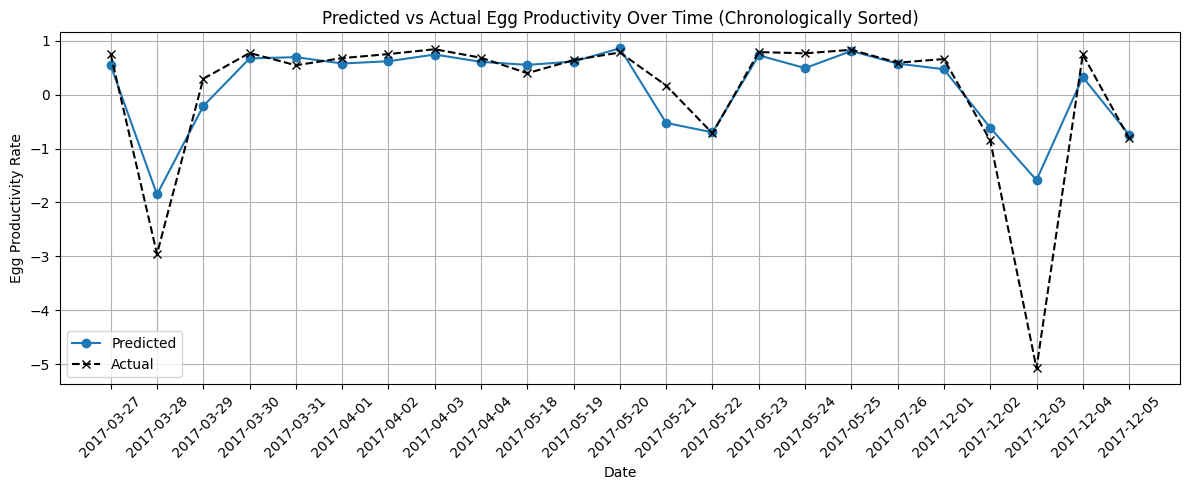

In [12]:
n = len(preds)
dates = eggs_per_day_df["date"].iloc[-n:].reset_index(drop=True)

# Combine into a single dataframe and sort by date
df_plot = pd.DataFrame({
    "date": dates,
    "predicted": preds,
    "actual": targets
}).sort_values("date")

plt.figure(figsize=(12, 5))
plt.plot(df_plot["date"], df_plot["predicted"], label="Predicted", marker='o')
plt.plot(df_plot["date"], df_plot["actual"], label="Actual", linestyle="--", color="black", marker='x')
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Egg Productivity Rate")
plt.title("Predicted vs Actual Egg Productivity Over Time (Chronologically Sorted)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 7) Evaluate

In [13]:
import pandas as pd

target = pd.read_csv("/kaggle/input/private-hen-productivity-target-labels/production_net.csv", sep=";")
eggs_per_day_df = target[["date", "Laying.rate...."]].rename(columns={"Laying.rate....": "productivity rate"})
eggs_per_day_df['productivity rate'] = eggs_per_day_df['productivity rate'].str.replace(',', '.').astype(float)
eggs_per_day_df.head(5)

,date,productivity rate
0,2017-02-27,94.960274
1,2017-03-01,94.260145
2,2017-04-25,92.655367
3,2017-07-12,89.730444
4,2017-07-22,88.271474


In [14]:
mean_eggs = eggs_per_day_df["productivity rate"].mean()
std_eggs = eggs_per_day_df["productivity rate"].std()

print(f"Mean productivity rate: {mean_eggs:.2f}")
print(f"Standard deviation of productivity rate: {std_eggs:.2f}")

Mean productivity rate: 87.16
Standard deviation of productivity rate: 8.34


### Model Evaluation: Egg Productivity Prediction

#### Baseline Statistics
- **Mean productivity rate**: 87.16  
- **Standard deviation**: 8.34  

---

#### Model 1: Global Mean Pooling
- **Average RMSE**: 0.8849 ± 0.1837
- **Average MAE**: 0.6840 ± 0.1426
- **Analysis**:  
  Highest error among all models. The high MAE and RMSE suggest that mean pooling fails to capture meaningful variation between nodes, likely due to oversimplification of node-level features.

---

#### Model 2: Global Max Pooling
- **Average RMSE**: 0.7737 ± 0.2112
- **Average MAE**: 0.6212 ± 0.0937
- **Analysis**:  
  Substantial improvement over mean pooling, particularly in RMSE. Max pooling may help highlight dominant node signals, but still shows weak overall performance.

---

#### Model 3: Global Attention Pooling
- **Average RMSE**: 0.5113 ± 0.1472
- **Average MAE**: 0.3247 ± 0.0232
- **Analysis**:  
  Best performance overall. The attention mechanism helps the model focus on the most relevant nodes, improving accuracy and reducing error. MAE (0.3247) is roughly 1/26th of the standard deviation, indicating strong predictive performance relative to data variability.

---

#### Overall Insights
- Switching from mean or max pooling to attention pooling substantially reduced prediction error.  
- Attention pooling outperformed both mean and max in terms of both RMSE and MAE.  
- The lower standard deviation in model 3's error metrics suggests more consistent predictions across samples.
- The MAE (0.3247) of attention pooling is roughly **1/26th** of the standard deviation, indicating a strong predictive performance relative to data variability.